## Prepare

In [96]:
# ! python3 -V

In [97]:
# ! pip install -r requirements.txt

In [98]:
# ! wget -O dacapo-bench.jar https://downloads.sourceforge.net/project/dacapobench/9.12-bach-MR1/dacapo-9.12-MR1-bach.jar
# ! wget -O gcviewer-1.36.jar http://sourceforge.net/projects/gcviewer/files/gcviewer-1.36.jar/download
# ! wget -O jdk.tar.gz https://download.bell-sw.com/java/11.0.20+8/bellsoft-jdk11.0.20+8-linux-amd64.tar.gz
# # MACOS
# # ! wget -O jdk.tar.gz https://download.bell-sw.com/java/11.0.20.1+1/bellsoft-jdk11.0.20.1+1-macos-amd64.tar.gz
# # ! wget -O jdk.zip https://download.bell-sw.com/java/11.0.20.1+1/bellsoft-jdk11.0.20.1+1-windows-amd64.zip
# # ! wget https://sourceforge.net/projects/gcviewer/files/gcviewer-1.36.jar/download
# ! tar xzf jdk.tar.gz && rm -fv jdk.tar.gz
# ! java -version

In [99]:
# ! ./jdk-11.0.20/bin/java -jar dacapo/dacapochopin.jar -l

In [100]:
# !  ./jdk-11.0.20/bin/java -jar dacapo-bench.jar xalan

In [101]:
# ! ./jdk-11.0.20/bin/java -XX:+UseParallelGC -Xmx4g -Xms128m  -cp dacapo-bench.jar \
# -Xlog:gc=debug:file=gc-avrora.txt -Dvmstat.enable_jfr=yes \
# -Dvmstat.csv=yes Harness -v -n 5 xalan

In [102]:
# ! pip install gym
# ! mkdir /home/ellkrauze/tmp
# ! export TMPDIR=/home/ellkrauze/tmp && pip install tensorflow
# ! export TMPDIR=/home/ellkrauze/tmp && pip install protobuf==3.20.*
# ! export TMPDIR=/home/ellkrauze/tmp && pip  install --force-reinstall -U tensorflow==2.3.0 keras keras-rl2 h5py==2.10.*


### GCViewer

In [103]:
# # Download jar from http://sourceforge.net/projects/gcviewer/files/gcviewer-1.36.jar/download
# ! java -cp gcviewer-1.36.jar com.tagtraum.perf.gcviewer.GCViewer gc-avrora.txt summary.csv -t SUMMARY

# Tensorflow DQN

In [1]:
import os
import imageio
import logging
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network, sequential, actor_distribution_network
from tf_agents.policies import random_tf_policy, random_py_policy, policy_saver
from tf_agents.replay_buffers import tf_uniform_replay_buffer, py_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import tensor_spec, from_spec
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

# from env.PyEnvironments import CurveEnv, CurveMultipleEnv, JVMEnv
# from env.PyEnvironments import JVMEnv
from env.PyEnvironmentsTest import JVMEnv # !!!

from tf_agents.environments.wrappers import TimeLimit 
from tf_agents.agents.reinforce import reinforce_agent
from tf_agents import trajectories

2023-11-20 13:31:31.363285: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 13:31:33.494478: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 13:31:33.507062: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 13:31:39.568584: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
TEST_JDK_PATH = "/home/vsakovskaya/gc-ml/jdk-11.0.20"
BM = "avrora"
BM_TEST = "kafka"
BM_PATH = "/home/vsakovskaya/gc-ml/dacapo/dacapochopin.jar"
CALLBACK_PATH = "/home/vsakovskaya/gc-ml/dacapo/DacapoCallback/DacapoChopin/VMStatCallback.java"
dataset_path = "dataset/data"
tempdir = "tmp"
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
policy_dir = os.path.join(tempdir, 'policy')

env = JVMEnv(jdk=TEST_JDK_PATH, bm_path=BM_PATH, 
    callback_path=CALLBACK_PATH, bm=BM, verbose=True)

env_test = JVMEnv(jdk=TEST_JDK_PATH, bm_path=BM_PATH, 
        callback_path=CALLBACK_PATH, bm=BM_TEST, verbose=True)

train_env = tf_py_environment.TFPyEnvironment(env, isolation=True)
eval_env = tf_py_environment.TFPyEnvironment(env, isolation=True)
test_env = tf_py_environment.TFPyEnvironment(env_test)

action_spec = from_spec(train_env.action_spec())
observation_spec = from_spec(train_env.observation_spec())
reward_spec = from_spec(train_env.reward_spec())
time_step_spec = trajectories.time_step_spec(observation_spec, reward_spec)

Successfully initialized a JVM Environment!
 JDK: /home/vsakovskaya/gc-ml/jdk-11.0.20/bin,
 Benchmark: avrora (/home/vsakovskaya/gc-ml/dacapo/dacapochopin.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.47],
 Env. default goal value: 0.47,

Successfully initialized a JVM Environment!
 JDK: /home/vsakovskaya/gc-ml/jdk-11.0.20/bin,
 Benchmark: kafka (/home/vsakovskaya/gc-ml/dacapo/dacapochopin.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.34],
 Env. default goal value: 0.34,



In [24]:
def get_q_net(action_spec, fc_layer_params = (100, 75, 50)):
    # fc_layer_params = (100, 75, 50)
    action_tensor_spec = tensor_spec.from_spec(action_spec)
    num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

    def dense_layer(num_units):
        """
        Define a helper function to create Dense layers configured 
        with the right activation and kernel initializer.
        """
        return tf.keras.layers.Dense(
            num_units,
            activation=tf.keras.activations.relu,
            kernel_initializer=tf.keras.initializers.VarianceScaling(
                scale=2.0, mode='fan_in', distribution='truncated_normal'))

    # QNetwork consists of a sequence of Dense layers followed by a dense layer
    # with `num_actions` units to generate one q_value per available action as
    # its output.
    dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
    q_values_layer = tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.keras.initializers.RandomUniform(
            minval=-0.03, maxval=0.03),
        bias_initializer=tf.keras.initializers.Constant(-0.2))
    q_net = sequential.Sequential(dense_layers + [q_values_layer])
    return q_net

def collect_step(environment, policy, replay_buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)

    next_time_step = environment.step(action_step.action)
    # reward = next_time_step.reward
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    return traj

def save_dataset(data, path):
    step_counter = tf.Variable(0, trainable=False)
    checkpoint_prefix = "checkpoint"
    checkpoint_args = {
        "checkpoint_interval": 50,
        "step_counter": step_counter,
        "directory": checkpoint_prefix,
        "max_to_keep": 3,
    }
    try:
        data.save(path, checkpoint_args=checkpoint_args)
    except:
        pass

def save_rb(replay_buffer, path):
    tf.train.Checkpoint(rb = replay_buffer).save(path)

def restore_rb(replay_buffer, path):
    tf.train.Checkpoint(rb = replay_buffer).restore(path)

def get_dataset(replay_buffer, size, batch_size, collect_data_spec, n_step_update, create: bool = True, save: bool = False):
    
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=collect_data_spec, # agent.collect_data_spec
        batch_size=1, # train_env.batch_size
        max_length=size) # capacity

    if create:
        for _ in tqdm(range(size)):
            traj = collect_step(train_env, random_policy, replay_buffer)
            replay_buffer.add_batch(traj)

        if save: save_rb(replay_buffer, dataset_path)
    else: 
        restore_rb(replay_buffer, dataset_path+'-1')

    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3, 
        sample_batch_size=batch_size,
        num_steps=n_step_update + 1, 
        single_deterministic_pass=False).prefetch(3)
    # iterator = iter(dataset)
    return dataset
    
def compute_avg_return(environment, policy, num_episodes=50):
    """
    Computes the average return of a policy, 
    given the policy, environment, and a number of episodes.

    Note: for non-episodic tasks.
    """
    total_return = 0.0
    time_step = environment.reset()
    for _ in tqdm(range(num_episodes)):
        action_step = policy.action(time_step, seed=42)
        time_step = environment.step(action_step.action)
        total_return += time_step.reward

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def compute_avg_return_episodic(environment, policy, num_episodes=10):
    """
    Computes the average return of a policy, 
    given the policy, environment, and a number of episodes.

    Note: for episodic tasks.
    """
    total_return = 0.0
    for _ in tqdm(range(num_episodes)):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            # print("time step:", action_step)
            # print("action:", action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [9]:
collect_steps_per_iteration = 1
dataset_size = 10000
fc_layer_params = (100, 75, 50)

batch_size = 128
learning_rate = 1e-6

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}
n_step_update = 10

agent_args = {
    "q_network": 
        get_q_net(action_spec, fc_layer_params),
    "optimizer": 
        tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate),
    "n_step_update": n_step_update, 
    "td_errors_loss_fn": tf.keras.losses.MeanSquaredError(),
    "epsilon_greedy": 0.9,  # Probability of choosing a random action
    "target_update_period": 1000,
    "gamma": 0.9999,        # The importance of future rewards
    "gradient_clipping": 1,
    "train_step_counter": 
        tf.compat.v1.train.get_or_create_global_step(),
}

In [14]:
# optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
# train_step_counter = tf.Variable(0)
# global_step = tf.compat.v1.train.get_or_create_global_step()
# q_net = get_q_net(action_spec, fc_layer_params)

agent = dqn_agent.DqnAgent(
  time_step_spec,
  action_spec,
  **agent_args
)

agent.initialize()

random_policy = random_tf_policy.RandomTFPolicy(
  time_step_spec = time_step_spec,
  action_spec = action_spec,
  automatic_state_reset=True,
  clip=False
)

# dataset = get_dataset(replay_buffer,
#   dataset_size, batch_size, agent.collect_data_spec, n_step_update)
# iterator = iter(dataset)

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec, # agent.collect_data_spec
    batch_size=train_env.batch_size, # train_env.batch_size
    max_length=dataset_size) # capacity

create = True
save = False
if create:
    for _ in tqdm(range(dataset_size)):
        traj = collect_step(train_env, random_policy, replay_buffer)
        replay_buffer.add_batch(traj)
    if save: save_rb(replay_buffer, dataset_path)
else: 
    restore_rb(replay_buffer, dataset_path+'-1')

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size,
    num_steps=n_step_update + 1, 
    single_deterministic_pass=False).prefetch(3)

iterator = iter(dataset)

  0%|          | 38/10000 [00:00<00:57, 174.03it/s]

100%|██████████| 10000/10000 [00:51<00:00, 193.93it/s]


### [Optional] Visualize Dataset

In [111]:
x = []
y = []
pairs = []
rews = []
for each in trajectories:
    pairs.append(each[0].numpy()[0])
    x.append(each[0][0][0].numpy())
    y.append(each[0][0][1].numpy())
    rews.append(each[1])
    # print(each[1])

# rewards_df = pd.DataFrame(pairs, rews, columns=["MaxTenuringThreshold", "ParallelGCThreads"])
# rewards_df = rewards_df.reset_index()
# rewards_df = rewards_df.rename(columns={'index': 'reward'})

# rewards_df.sort_values(by='reward', ascending=False)

<Axes: title={'center': 'Frequency of flag pairs in a dataset'}, xlabel='MaxTenuringThreshold,ParallelGCThreads'>

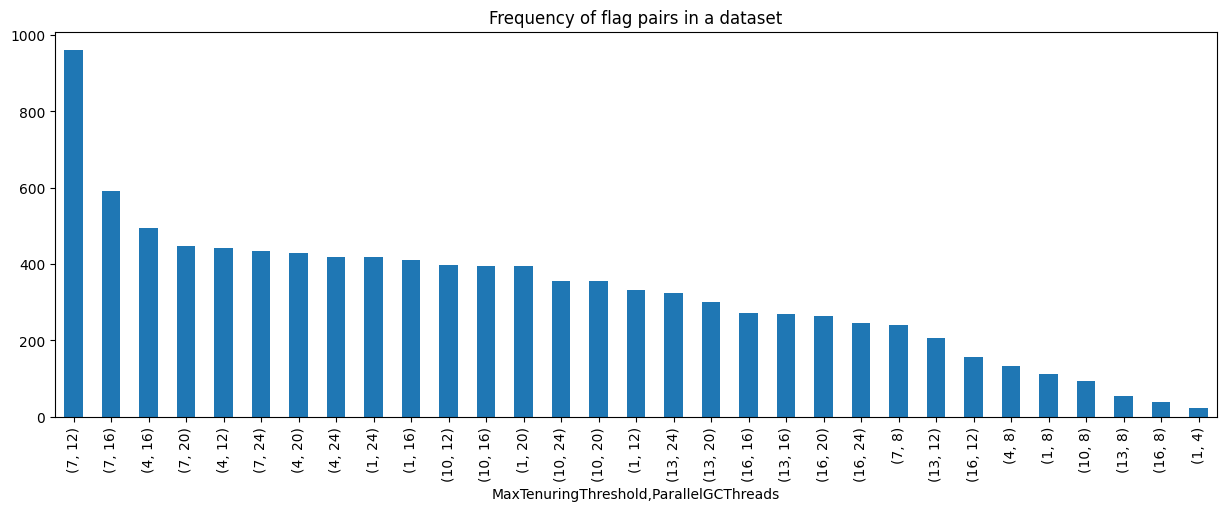

In [112]:
import pandas as pd

df = pd.DataFrame(pairs, columns=["MaxTenuringThreshold", "ParallelGCThreads"])
df.value_counts().head(100).plot(figsize=(15,5), kind='bar', title="Frequency of flag pairs in a dataset")

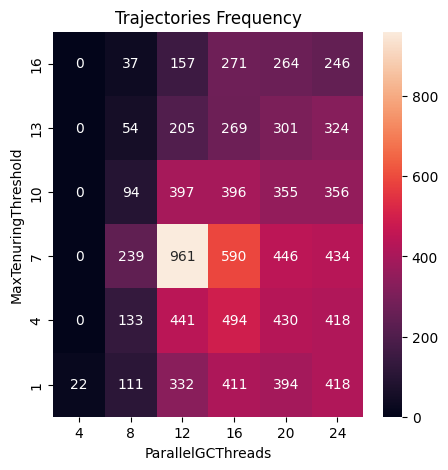

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(5, 5))
x = df.pivot_table(index='MaxTenuringThreshold',columns='ParallelGCThreads',aggfunc='size',fill_value=0)
idx = x.max(axis=1).sort_values(ascending=0).index
sns.heatmap(x, annot=True, ax=ax, fmt="")
ax.set_title("Trajectories Frequency")
ax.invert_yaxis()
plt.show()

Plot data as heatmap.

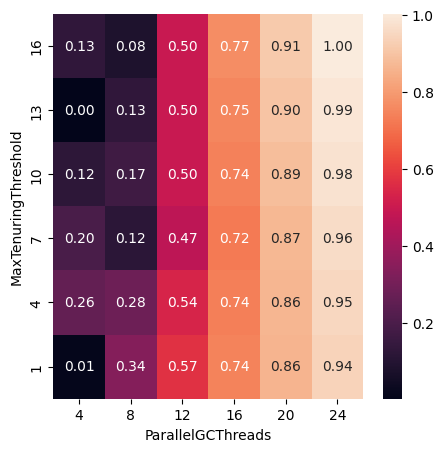

In [114]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 5))
cached_states = env._perf_states
X = [cached_states[i]["args"][0] for i in cached_states.keys()]
Y = [cached_states[i]["args"][1] for i in cached_states.keys()]
Z = [cached_states[i]["goal"] for i in cached_states.keys()]

data = pd.DataFrame({'MaxTenuringThreshold': X, 'ParallelGCThreads': Y, 'Average GC Pause': Z})
data_pivoted = data.pivot("MaxTenuringThreshold", "ParallelGCThreads", "Average GC Pause")
ax = sns.heatmap(data_pivoted, annot=True, ax=ax, fmt=".2f")
ax.invert_yaxis()
plt.show()

## Agent Training

In [12]:
def train(_agent, _env_train, _env_val, 
          steps: int = 5000, 
          use_wandb: bool = False):
    """
    Train reinforcement learning agent and evaluate
    performance on a separate environment.
    """
    seed = 42
    total_return = 0.0
    eval_interval = 100

    _env_train.reset()
    _env_val.reset()
    
    _agent.train = common.function(_agent.train)
    _agent.train_step_counter.assign(0)
    _agent.initialize()
    time_step = _env_val.reset()
    policy_state = _agent.collect_policy.get_initial_state(_env_train.batch_size)

    loss = []
    observations = []

    rewards = []
    # avg_reward = compute_avg_return(_env_val, _agent.policy, num_episodes=50)
    # rewards = [avg_reward]

    for _ in tqdm(range(steps)):

        # Add new trajectory to buffer with agent's collect_policy.
        for _ in range(collect_steps_per_iteration):
            traj = collect_step(_env_train, _agent.collect_policy, replay_buffer)
            replay_buffer.add_batch(traj)

        # Update the dataset.
        _dataset = replay_buffer.as_dataset(
            num_parallel_calls=3, 
            sample_batch_size=batch_size,
            num_steps=n_step_update + 1, 
            single_deterministic_pass=False).prefetch(3)

        _iterator = iter(_dataset)

        # Iterate through the dataset, get a trajectory to learn.
        experience, _ = next(_iterator)
        train_loss = _agent.train(experience)

        # Calculate a reward on evaluation environment
        policy_step = _agent.policy.action(time_step, seed=seed)
        time_step = _env_val.step(policy_step.action)
        rwd = time_step.reward.numpy()[0]
        obs = time_step.observation.numpy()[0]
        total_return += rwd # Calculate a sum of rewards

        step = _agent.train_step_counter.numpy()

        if step % eval_interval == 0:
            avg_reward = total_return / eval_interval
            # avg_reward = compute_avg_return(_env_val, _agent.policy, num_episodes=50)
            # avg_reward = compute_avg_return_episodic(_env_val, _agent.policy, num_episodes=50)
            total_return = 0.0 # reset

            loss.append(train_loss.loss.numpy())
            observations.append(obs)
            rewards.append(avg_reward)

            # wandb logger for tuning hyperparameters
            if use_wandb:
                wandb.log({'loss': train_loss.loss, 'reward': avg_reward})

            print(f"step = {step}: loss = {train_loss.loss}, reward = {avg_reward}")
    
    return loss, observations, rewards

In [7]:
loss, observations, rewards = train(agent, train_env, eval_env, steps = 100000)

  0%|          | 0/100000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
  0%|          | 101/100000 [00:17<6:31:05,  4.26it/s]

step = 100: loss = 5.893207550048828, reward = -0.05968308076262474


  0%|          | 201/100000 [00:32<6:09:30,  4.50it/s]

step = 200: loss = 6.516745090484619, reward = -0.05968308076262474


  0%|          | 301/100000 [00:49<6:11:39,  4.47it/s]

step = 300: loss = 4.960230827331543, reward = -0.05968308076262474


  0%|          | 401/100000 [01:05<6:17:19,  4.40it/s]

step = 400: loss = 5.0672478675842285, reward = -0.05968308076262474


  1%|          | 501/100000 [01:21<6:12:32,  4.45it/s]

step = 500: loss = 5.489706993103027, reward = -0.05968308076262474


  1%|          | 601/100000 [01:37<7:11:48,  3.84it/s]

step = 600: loss = 4.275213718414307, reward = -0.05968308076262474


  1%|          | 701/100000 [01:53<6:17:03,  4.39it/s]

step = 700: loss = 4.87294340133667, reward = -0.05968308076262474


  1%|          | 801/100000 [02:09<6:13:08,  4.43it/s]

step = 800: loss = 3.160245418548584, reward = -0.05968308076262474


  1%|          | 901/100000 [02:26<6:21:39,  4.33it/s]

step = 900: loss = 3.745388984680176, reward = -0.05968308076262474


  1%|          | 1001/100000 [02:42<6:33:52,  4.19it/s]

step = 1000: loss = 3.5453901290893555, reward = -0.05968308076262474


  1%|          | 1101/100000 [02:58<6:06:53,  4.49it/s]

step = 1100: loss = 2.9596166610717773, reward = -0.05968308076262474


  1%|          | 1201/100000 [03:14<6:12:09,  4.42it/s]

step = 1200: loss = 3.16778826713562, reward = -0.05968308076262474


  1%|▏         | 1301/100000 [03:30<6:26:42,  4.25it/s]

step = 1300: loss = 2.4223172664642334, reward = -0.05968308076262474


  1%|▏         | 1401/100000 [03:46<6:06:41,  4.48it/s]

step = 1400: loss = 2.227186679840088, reward = -0.05968308076262474


  2%|▏         | 1501/100000 [04:03<6:16:33,  4.36it/s]

step = 1500: loss = 2.502336025238037, reward = -0.05968308076262474


  2%|▏         | 1601/100000 [04:19<6:55:20,  3.95it/s]

step = 1600: loss = 2.148024320602417, reward = -0.05968308076262474


  2%|▏         | 1701/100000 [04:35<6:10:11,  4.43it/s]

step = 1700: loss = 1.8371081352233887, reward = -0.05968308076262474


  2%|▏         | 1801/100000 [04:52<6:32:45,  4.17it/s]

step = 1800: loss = 1.7039093971252441, reward = -0.05968308076262474


  2%|▏         | 1901/100000 [05:08<6:06:47,  4.46it/s]

step = 1900: loss = 1.808540940284729, reward = -0.05968308076262474


  2%|▏         | 2001/100000 [05:25<6:09:38,  4.42it/s]

step = 2000: loss = 1.9882099628448486, reward = -0.05968308076262474


  2%|▏         | 2101/100000 [05:41<8:47:10,  3.10it/s] 

step = 2100: loss = 1.0505644083023071, reward = -0.05968308076262474


  2%|▏         | 2201/100000 [05:57<6:09:32,  4.41it/s]

step = 2200: loss = 0.9644840359687805, reward = -0.05968308076262474


  2%|▏         | 2301/100000 [06:14<6:24:49,  4.23it/s]

step = 2300: loss = 1.3407111167907715, reward = -0.05968308076262474


  2%|▏         | 2401/100000 [06:30<6:02:34,  4.49it/s]

step = 2400: loss = 1.1373982429504395, reward = -0.05968308076262474


  3%|▎         | 2501/100000 [06:47<6:10:20,  4.39it/s]

step = 2500: loss = 1.026979923248291, reward = -0.05968308076262474


  3%|▎         | 2601/100000 [07:03<6:13:26,  4.35it/s]

step = 2600: loss = 0.8597115874290466, reward = -0.05968308076262474


  3%|▎         | 2701/100000 [07:20<6:18:01,  4.29it/s]

step = 2700: loss = 0.8786909580230713, reward = -0.05968308076262474


  3%|▎         | 2801/100000 [07:35<6:03:43,  4.45it/s]

step = 2800: loss = 0.665337860584259, reward = -0.05968308076262474


  3%|▎         | 2901/100000 [07:52<6:26:50,  4.18it/s]

step = 2900: loss = 0.7794921398162842, reward = -0.05968308076262474


  3%|▎         | 3001/100000 [08:08<5:59:37,  4.50it/s]

step = 3000: loss = 0.8043259382247925, reward = -0.05968308076262474


  3%|▎         | 3101/100000 [08:25<6:27:21,  4.17it/s]

step = 3100: loss = 0.46449577808380127, reward = -0.05968308076262474


  3%|▎         | 3201/100000 [08:41<5:56:06,  4.53it/s]

step = 3200: loss = 0.37182915210723877, reward = -0.05968308076262474


  3%|▎         | 3301/100000 [08:58<6:12:09,  4.33it/s]

step = 3300: loss = 0.29514187574386597, reward = -0.05968308076262474


  3%|▎         | 3401/100000 [09:14<6:19:02,  4.25it/s]

step = 3400: loss = 0.3074015974998474, reward = -0.05968308076262474


  4%|▎         | 3501/100000 [09:31<6:14:45,  4.29it/s]

step = 3500: loss = 0.3517525792121887, reward = -0.05968308076262474


  4%|▎         | 3601/100000 [09:46<6:01:55,  4.44it/s]

step = 3600: loss = 0.33631962537765503, reward = -0.05968308076262474


  4%|▎         | 3701/100000 [10:03<6:09:19,  4.35it/s]

step = 3700: loss = 0.35643520951271057, reward = -0.05968308076262474


  4%|▍         | 3801/100000 [10:19<5:52:35,  4.55it/s]

step = 3800: loss = 0.29966577887535095, reward = -0.05968308076262474


  4%|▍         | 3901/100000 [10:36<6:35:44,  4.05it/s]

step = 3900: loss = 0.36388471722602844, reward = -0.05968308076262474


  4%|▍         | 4001/100000 [10:52<6:03:59,  4.40it/s]

step = 4000: loss = 0.25733697414398193, reward = -0.05968308076262474


  4%|▍         | 4101/100000 [11:09<7:15:04,  3.67it/s]

step = 4100: loss = 0.19923362135887146, reward = -0.05968308076262474


  4%|▍         | 4201/100000 [11:25<6:00:08,  4.43it/s]

step = 4200: loss = 0.16904544830322266, reward = -0.05968308076262474


  4%|▍         | 4301/100000 [11:40<6:03:57,  4.38it/s]

step = 4300: loss = 0.15712790191173553, reward = -0.05968308076262474


  4%|▍         | 4401/100000 [11:57<5:54:55,  4.49it/s]

step = 4400: loss = 0.1775113344192505, reward = -0.05968308076262474


  5%|▍         | 4501/100000 [12:13<5:53:49,  4.50it/s]

step = 4500: loss = 0.1482173055410385, reward = -0.05968308076262474


  5%|▍         | 4601/100000 [12:30<6:13:17,  4.26it/s]

step = 4600: loss = 0.1816919445991516, reward = -0.05968308076262474


  5%|▍         | 4701/100000 [12:46<5:56:38,  4.45it/s]

step = 4700: loss = 0.16864243149757385, reward = -0.05968308076262474


  5%|▍         | 4801/100000 [13:02<10:39:33,  2.48it/s]

step = 4800: loss = 0.1377800703048706, reward = -0.05968308076262474


  5%|▍         | 4901/100000 [13:19<5:56:00,  4.45it/s]

step = 4900: loss = 0.16653098165988922, reward = -0.05968308076262474


  5%|▌         | 5001/100000 [13:34<5:55:27,  4.45it/s]

step = 5000: loss = 0.17604216933250427, reward = -0.05968308076262474


  5%|▌         | 5101/100000 [13:52<6:03:47,  4.35it/s]

step = 5100: loss = 0.12324091792106628, reward = -0.05968308076262474


  5%|▌         | 5201/100000 [14:07<6:00:06,  4.39it/s]

step = 5200: loss = 0.0819769948720932, reward = -0.05968308076262474


  5%|▌         | 5301/100000 [14:23<5:53:36,  4.46it/s]

step = 5300: loss = 0.11529935151338577, reward = -0.05968308076262474


  5%|▌         | 5401/100000 [14:40<5:57:45,  4.41it/s]

step = 5400: loss = 0.09360943734645844, reward = -0.05968308076262474


  6%|▌         | 5501/100000 [14:56<5:37:27,  4.67it/s]

step = 5500: loss = 0.0918731689453125, reward = -0.05968308076262474


  6%|▌         | 5601/100000 [15:13<6:23:43,  4.10it/s]

step = 5600: loss = 0.09239242970943451, reward = -0.05968308076262474


  6%|▌         | 5701/100000 [15:29<5:51:32,  4.47it/s]

step = 5700: loss = 0.08297939598560333, reward = -0.05968308076262474


  6%|▌         | 5801/100000 [15:45<5:58:11,  4.38it/s]

step = 5800: loss = 0.0975584164261818, reward = -0.05968308076262474


  6%|▌         | 5901/100000 [16:02<6:01:03,  4.34it/s]

step = 5900: loss = 0.09583472460508347, reward = -0.05968308076262474


  6%|▌         | 6001/100000 [16:18<5:59:20,  4.36it/s]

step = 6000: loss = 0.09552840888500214, reward = -0.05968308076262474


  6%|▌         | 6101/100000 [16:33<5:42:40,  4.57it/s]

step = 6100: loss = 0.07711655646562576, reward = -0.05968308076262474


  6%|▌         | 6201/100000 [16:51<6:21:58,  4.09it/s]

step = 6200: loss = 0.08695158362388611, reward = -0.05968308076262474


  6%|▋         | 6301/100000 [17:07<6:07:38,  4.25it/s]

step = 6300: loss = 0.05461864173412323, reward = -0.05968308076262474


  6%|▋         | 6401/100000 [17:22<5:51:43,  4.44it/s]

step = 6400: loss = 0.10406787693500519, reward = -0.05968308076262474


  7%|▋         | 6501/100000 [17:40<6:03:16,  4.29it/s]

step = 6500: loss = 0.07262333482503891, reward = -0.05968308076262474


  7%|▋         | 6601/100000 [17:56<5:47:27,  4.48it/s]

step = 6600: loss = 0.11174934357404709, reward = -0.05968308076262474


  7%|▋         | 6701/100000 [18:11<5:45:19,  4.50it/s]

step = 6700: loss = 0.06403674930334091, reward = -0.05968308076262474


  7%|▋         | 6801/100000 [18:29<6:21:23,  4.07it/s]

step = 6800: loss = 0.06635741889476776, reward = -0.05968308076262474


  7%|▋         | 6901/100000 [18:45<5:46:32,  4.48it/s]

step = 6900: loss = 0.046672649681568146, reward = -0.05968308076262474


  7%|▋         | 7001/100000 [19:01<5:44:40,  4.50it/s]

step = 7000: loss = 0.10265494883060455, reward = -0.05968308076262474


  7%|▋         | 7101/100000 [19:18<6:14:01,  4.14it/s]

step = 7100: loss = 0.05843584984540939, reward = -0.05968308076262474


  7%|▋         | 7201/100000 [19:34<5:55:59,  4.34it/s]

step = 7200: loss = 0.06995603442192078, reward = -0.05968308076262474


  7%|▋         | 7301/100000 [19:50<5:52:21,  4.38it/s]

step = 7300: loss = 0.06876067817211151, reward = -0.05968308076262474


  7%|▋         | 7401/100000 [20:08<6:22:22,  4.04it/s]

step = 7400: loss = 0.06878416240215302, reward = -0.05968308076262474


  8%|▊         | 7501/100000 [20:24<5:46:18,  4.45it/s]

step = 7500: loss = 0.08800965547561646, reward = -0.05968308076262474


  8%|▊         | 7601/100000 [20:39<5:48:22,  4.42it/s]

step = 7600: loss = 0.06695853173732758, reward = -0.05968308076262474


  8%|▊         | 7701/100000 [20:56<12:12:48,  2.10it/s]

step = 7700: loss = 0.04220530390739441, reward = -0.05968308076262474


  8%|▊         | 7801/100000 [21:13<5:39:06,  4.53it/s]

step = 7800: loss = 0.06008169800043106, reward = -0.05968308076262474


  8%|▊         | 7901/100000 [21:28<5:40:01,  4.51it/s]

step = 7900: loss = 0.0481516532599926, reward = -0.05968308076262474


  8%|▊         | 8001/100000 [21:44<5:37:43,  4.54it/s]

step = 8000: loss = 0.08771057426929474, reward = -0.05968308076262474


  8%|▊         | 8101/100000 [22:02<5:51:51,  4.35it/s]

step = 8100: loss = 0.05323002487421036, reward = -0.05968308076262474


  8%|▊         | 8201/100000 [22:18<5:54:47,  4.31it/s]

step = 8200: loss = 0.05103050172328949, reward = -0.05968308076262474


  8%|▊         | 8301/100000 [22:33<5:44:38,  4.43it/s]

step = 8300: loss = 0.04050031304359436, reward = -0.05968308076262474


  8%|▊         | 8401/100000 [22:51<6:07:24,  4.16it/s]

step = 8400: loss = 0.05185268819332123, reward = -0.05968308076262474


  9%|▊         | 8501/100000 [23:07<5:32:49,  4.58it/s]

step = 8500: loss = 0.037289731204509735, reward = -0.05968308076262474


  9%|▊         | 8601/100000 [23:23<5:42:12,  4.45it/s]

step = 8600: loss = 0.058630894869565964, reward = -0.05968308076262474


  9%|▊         | 8701/100000 [23:38<5:36:23,  4.52it/s]

step = 8700: loss = 0.039655476808547974, reward = -0.05968308076262474


  9%|▉         | 8801/100000 [23:57<5:54:23,  4.29it/s]

step = 8800: loss = 0.041334763169288635, reward = -0.05968308076262474


  9%|▉         | 8901/100000 [24:12<5:46:33,  4.38it/s]

step = 8900: loss = 0.03633979707956314, reward = -0.05968308076262474


  9%|▉         | 9001/100000 [24:28<5:48:20,  4.35it/s]

step = 9000: loss = 0.03390982747077942, reward = -0.05968308076262474


  9%|▉         | 9101/100000 [24:44<5:39:20,  4.46it/s]

step = 9100: loss = 0.031483981758356094, reward = -0.05968308076262474


  9%|▉         | 9201/100000 [25:02<5:41:26,  4.43it/s]

step = 9200: loss = 0.0476854182779789, reward = -0.05968308076262474


  9%|▉         | 9301/100000 [25:18<5:40:38,  4.44it/s]

step = 9300: loss = 0.0447440966963768, reward = -0.05968308076262474


  9%|▉         | 9401/100000 [25:34<5:40:38,  4.43it/s]

step = 9400: loss = 0.050130851566791534, reward = -0.05968308076262474


 10%|▉         | 9501/100000 [25:52<6:14:12,  4.03it/s]

step = 9500: loss = 0.042064864188432693, reward = -0.05968308076262474


 10%|▉         | 9601/100000 [26:08<5:33:52,  4.51it/s]

step = 9600: loss = 0.041693635284900665, reward = -0.05968308076262474


 10%|▉         | 9701/100000 [26:23<5:37:40,  4.46it/s]

step = 9700: loss = 0.025211233645677567, reward = -0.05968308076262474


 10%|▉         | 9801/100000 [26:39<5:50:17,  4.29it/s]

step = 9800: loss = 0.022254634648561478, reward = -1.0


 10%|▉         | 9901/100000 [26:57<5:59:50,  4.17it/s]

step = 9900: loss = 0.02521364949643612, reward = -0.05968308076262474


 10%|█         | 10001/100000 [27:13<5:40:41,  4.40it/s]

step = 10000: loss = 0.033798862248659134, reward = -0.05968308076262474


 10%|█         | 10101/100000 [27:29<5:32:34,  4.51it/s]

step = 10100: loss = 0.017370032146573067, reward = -0.05968308076262474


 10%|█         | 10201/100000 [27:44<5:33:44,  4.48it/s]

step = 10200: loss = 0.00788869522511959, reward = -0.05968308076262474


 10%|█         | 10301/100000 [28:03<5:48:02,  4.30it/s]

step = 10300: loss = 0.024674611166119576, reward = -0.05968308076262474


 10%|█         | 10401/100000 [28:19<5:40:54,  4.38it/s]

step = 10400: loss = 0.02395610511302948, reward = -0.05968308076262474


 11%|█         | 10501/100000 [28:35<5:45:02,  4.32it/s]

step = 10500: loss = 0.011549578979611397, reward = -0.05968308076262474


 11%|█         | 10601/100000 [28:50<5:30:18,  4.51it/s]

step = 10600: loss = 0.027084000408649445, reward = -0.05968308076262474


 11%|█         | 10701/100000 [29:09<5:54:29,  4.20it/s]

step = 10700: loss = 0.02670876868069172, reward = -0.05968308076262474


 11%|█         | 10801/100000 [29:25<5:44:33,  4.31it/s]

step = 10800: loss = 0.042369913309812546, reward = -0.05968308076262474


 11%|█         | 10901/100000 [29:41<5:29:17,  4.51it/s]

step = 10900: loss = 0.03718509525060654, reward = -0.05968308076262474


 11%|█         | 11001/100000 [29:56<5:35:30,  4.42it/s]

step = 11000: loss = 0.03379322215914726, reward = -0.05968308076262474


 11%|█         | 11101/100000 [30:15<5:53:25,  4.19it/s]

step = 11100: loss = 0.017457295209169388, reward = -0.05968308076262474


 11%|█         | 11201/100000 [30:31<5:28:48,  4.50it/s]

step = 11200: loss = 0.0230080746114254, reward = -0.05968308076262474


 11%|█▏        | 11301/100000 [30:46<5:34:57,  4.41it/s]

step = 11300: loss = 0.037052322179079056, reward = -0.05968308076262474


 11%|█▏        | 11401/100000 [31:02<5:28:46,  4.49it/s]

step = 11400: loss = 0.02294258214533329, reward = -0.05968308076262474


 12%|█▏        | 11501/100000 [31:20<5:55:01,  4.15it/s]

step = 11500: loss = 0.022946534678339958, reward = -0.05968308076262474


 12%|█▏        | 11601/100000 [31:37<5:30:37,  4.46it/s]

step = 11600: loss = 0.02167995274066925, reward = -0.05968308076262474


 12%|█▏        | 11701/100000 [31:52<5:34:08,  4.40it/s]

step = 11700: loss = 0.01972350850701332, reward = -0.05968308076262474


 12%|█▏        | 11801/100000 [32:08<5:35:36,  4.38it/s]

step = 11800: loss = 0.026209352537989616, reward = -0.05968308076262474


 12%|█▏        | 11901/100000 [32:26<7:04:53,  3.46it/s]

step = 11900: loss = 0.01432602759450674, reward = -0.05968308076262474


 12%|█▏        | 12001/100000 [32:43<5:37:20,  4.35it/s]

step = 12000: loss = 0.029157251119613647, reward = -0.05968308076262474


 12%|█▏        | 12101/100000 [32:59<5:26:31,  4.49it/s]

step = 12100: loss = 0.014808712527155876, reward = -0.05968308076262474


 12%|█▏        | 12201/100000 [33:14<5:31:51,  4.41it/s]

step = 12200: loss = 0.03411998972296715, reward = -0.05968308076262474


 12%|█▏        | 12301/100000 [33:30<5:19:15,  4.58it/s]

step = 12300: loss = 0.015010954812169075, reward = -0.05968308076262474


 12%|█▏        | 12401/100000 [33:49<5:54:09,  4.12it/s]

step = 12400: loss = 0.023268653079867363, reward = -0.05968308076262474


 13%|█▎        | 12501/100000 [34:05<5:27:01,  4.46it/s]

step = 12500: loss = 0.0260939858853817, reward = -0.05968308076262474


 13%|█▎        | 12601/100000 [34:20<5:23:24,  4.50it/s]

step = 12600: loss = 0.031910575926303864, reward = -0.05968308076262474


 13%|█▎        | 12701/100000 [34:36<5:26:07,  4.46it/s]

step = 12700: loss = 0.04459243267774582, reward = -0.05968308076262474


 13%|█▎        | 12800/100000 [34:53<18:50:51,  1.29it/s]

step = 12800: loss = 0.022343609482049942, reward = -0.05968308076262474


 13%|█▎        | 12901/100000 [35:11<5:44:44,  4.21it/s]

step = 12900: loss = 0.01545616053044796, reward = -0.05968308076262474


 13%|█▎        | 13001/100000 [35:27<5:31:48,  4.37it/s]

step = 13000: loss = 0.019688962027430534, reward = -0.05968308076262474


 13%|█▎        | 13101/100000 [35:42<5:26:54,  4.43it/s]

step = 13100: loss = 0.0392252579331398, reward = -0.05968308076262474


 13%|█▎        | 13201/100000 [35:58<5:23:59,  4.47it/s]

step = 13200: loss = 0.034149169921875, reward = -0.05968308076262474


 13%|█▎        | 13301/100000 [36:16<6:15:27,  3.85it/s]

step = 13300: loss = 0.021173477172851562, reward = -0.05968308076262474


 13%|█▎        | 13401/100000 [36:33<5:21:52,  4.48it/s]

step = 13400: loss = 0.01799675263464451, reward = -0.05968308076262474


 14%|█▎        | 13501/100000 [36:49<5:26:09,  4.42it/s]

step = 13500: loss = 0.033594369888305664, reward = -0.05968308076262474


 14%|█▎        | 13601/100000 [37:04<5:24:44,  4.43it/s]

step = 13600: loss = 0.02795872464776039, reward = -0.05968308076262474


 14%|█▎        | 13701/100000 [37:20<5:23:16,  4.45it/s]

step = 13700: loss = 0.025304311886429787, reward = -0.05968308076262474


 14%|█▍        | 13801/100000 [37:39<5:45:26,  4.16it/s]

step = 13800: loss = 0.01748100109398365, reward = -0.05968308076262474


 14%|█▍        | 13901/100000 [37:55<5:18:59,  4.50it/s]

step = 13900: loss = 0.017123255878686905, reward = -0.05968308076262474


 14%|█▍        | 14001/100000 [38:11<5:26:47,  4.39it/s]

step = 14000: loss = 0.029345931485295296, reward = -0.05968308076262474


 14%|█▍        | 14101/100000 [38:27<5:25:32,  4.40it/s]

step = 14100: loss = 0.05528641492128372, reward = -0.05968308076262474


 14%|█▍        | 14201/100000 [38:42<5:16:31,  4.52it/s]

step = 14200: loss = 0.036815304309129715, reward = -0.05968308076262474


 14%|█▍        | 14301/100000 [39:02<5:42:49,  4.17it/s]

step = 14300: loss = 0.027149885892868042, reward = -0.05968308076262474


 14%|█▍        | 14401/100000 [39:18<5:17:34,  4.49it/s]

step = 14400: loss = 0.03633982315659523, reward = -0.05968308076262474


 15%|█▍        | 14501/100000 [39:33<5:21:03,  4.44it/s]

step = 14500: loss = 0.028521068394184113, reward = -0.05968308076262474


 15%|█▍        | 14601/100000 [39:49<5:23:49,  4.40it/s]

step = 14600: loss = 0.02378537505865097, reward = -0.05968308076262474


 15%|█▍        | 14701/100000 [40:05<5:31:21,  4.29it/s]

step = 14700: loss = 0.03212675452232361, reward = -0.05968308076262474


 15%|█▍        | 14801/100000 [40:24<5:40:49,  4.17it/s]

step = 14800: loss = 0.019141992554068565, reward = -0.05968308076262474


 15%|█▍        | 14901/100000 [40:40<5:12:18,  4.54it/s]

step = 14900: loss = 0.020196303725242615, reward = -0.05968308076262474


 15%|█▌        | 15001/100000 [40:56<5:35:56,  4.22it/s]

step = 15000: loss = 0.02647615782916546, reward = -0.05968308076262474


 15%|█▌        | 15101/100000 [41:12<5:20:35,  4.41it/s]

step = 15100: loss = 0.03434579819440842, reward = -0.05968308076262474


 15%|█▌        | 15201/100000 [41:27<5:20:31,  4.41it/s]

step = 15200: loss = 0.029339153319597244, reward = -0.05968308076262474


 15%|█▌        | 15301/100000 [41:46<5:55:35,  3.97it/s]

step = 15300: loss = 0.023182671517133713, reward = -0.05968308076262474


 15%|█▌        | 15401/100000 [42:03<5:15:03,  4.48it/s]

step = 15400: loss = 0.024689070880413055, reward = -0.05968308076262474


 16%|█▌        | 15501/100000 [42:19<5:20:26,  4.39it/s]

step = 15500: loss = 0.03111538290977478, reward = -0.05968308076262474


 16%|█▌        | 15601/100000 [42:34<5:11:10,  4.52it/s]

step = 15600: loss = 0.03407011181116104, reward = -0.05968308076262474


 16%|█▌        | 15701/100000 [42:50<5:08:22,  4.56it/s]

step = 15700: loss = 0.032290004193782806, reward = -0.05968308076262474


 16%|█▌        | 15800/100000 [43:08<8:21:54,  2.80it/s]

step = 15800: loss = 0.021258264780044556, reward = -0.05968308076262474


 16%|█▌        | 15901/100000 [43:26<5:48:02,  4.03it/s]

step = 15900: loss = 0.022127047181129456, reward = -0.05968308076262474


 16%|█▌        | 16001/100000 [43:41<5:17:09,  4.41it/s]

step = 16000: loss = 0.03780250996351242, reward = -0.05968308076262474


 16%|█▌        | 16101/100000 [43:57<5:14:17,  4.45it/s]

step = 16100: loss = 0.015462779439985752, reward = -0.05968308076262474


 16%|█▌        | 16201/100000 [44:13<5:11:08,  4.49it/s]

step = 16200: loss = 0.04434705525636673, reward = -0.05968308076262474


 16%|█▋        | 16301/100000 [44:28<5:17:51,  4.39it/s]

step = 16300: loss = 0.022775918245315552, reward = -0.05968308076262474


 16%|█▋        | 16401/100000 [44:48<5:36:39,  4.14it/s]

step = 16400: loss = 0.03580345958471298, reward = -0.05968308076262474


 17%|█▋        | 16501/100000 [45:05<5:09:23,  4.50it/s]

step = 16500: loss = 0.039608679711818695, reward = -0.05968308076262474


 17%|█▋        | 16601/100000 [45:20<5:13:06,  4.44it/s]

step = 16600: loss = 0.037427157163619995, reward = -0.05968308076262474


 17%|█▋        | 16701/100000 [45:36<5:18:04,  4.36it/s]

step = 16700: loss = 0.02840804122388363, reward = -0.05968308076262474


 17%|█▋        | 16801/100000 [45:51<5:09:56,  4.47it/s]

step = 16800: loss = 0.03281616047024727, reward = -0.05968308076262474


 17%|█▋        | 16900/100000 [46:09<14:19:51,  1.61it/s]

step = 16900: loss = 0.03347768262028694, reward = -0.05968308076262474


 17%|█▋        | 17001/100000 [46:28<5:26:43,  4.23it/s]

step = 17000: loss = 0.03793567046523094, reward = -0.05968308076262474


 17%|█▋        | 17101/100000 [46:44<5:14:24,  4.39it/s]

step = 17100: loss = 0.03476637601852417, reward = -0.05968308076262474


 17%|█▋        | 17201/100000 [46:59<5:14:01,  4.39it/s]

step = 17200: loss = 0.04547824710607529, reward = -0.05968308076262474


 17%|█▋        | 17301/100000 [47:15<5:06:18,  4.50it/s]

step = 17300: loss = 0.02541995979845524, reward = -0.05968308076262474


 17%|█▋        | 17401/100000 [47:31<5:19:54,  4.30it/s]

step = 17400: loss = 0.02339749224483967, reward = -0.05968308076262474


 18%|█▊        | 17501/100000 [47:50<5:53:59,  3.88it/s]

step = 17500: loss = 0.0267594326287508, reward = -0.05968308076262474


 18%|█▊        | 17601/100000 [48:07<5:26:08,  4.21it/s]

step = 17600: loss = 0.03734733164310455, reward = -0.05968308076262474


 18%|█▊        | 17701/100000 [48:23<5:02:00,  4.54it/s]

step = 17700: loss = 0.016405077651143074, reward = -0.05968308076262474


 18%|█▊        | 17801/100000 [48:39<5:05:55,  4.48it/s]

step = 17800: loss = 0.04513758793473244, reward = -0.05968308076262474


 18%|█▊        | 17901/100000 [48:54<5:02:31,  4.52it/s]

step = 17900: loss = 0.029987245798110962, reward = -0.05968308076262474


 18%|█▊        | 18001/100000 [49:10<5:05:25,  4.47it/s]

step = 18000: loss = 0.025244522839784622, reward = -0.05968308076262474


 18%|█▊        | 18101/100000 [49:30<5:48:18,  3.92it/s]

step = 18100: loss = 0.03209459409117699, reward = -0.05968308076262474


 18%|█▊        | 18201/100000 [49:47<5:15:40,  4.32it/s]

step = 18200: loss = 0.034314051270484924, reward = -0.05968308076262474


 18%|█▊        | 18301/100000 [50:02<5:10:30,  4.39it/s]

step = 18300: loss = 0.03104545921087265, reward = -0.05968308076262474


 18%|█▊        | 18401/100000 [50:18<5:05:10,  4.46it/s]

step = 18400: loss = 0.040270429104566574, reward = -0.05968308076262474


 19%|█▊        | 18501/100000 [50:33<5:07:10,  4.42it/s]

step = 18500: loss = 0.043516602367162704, reward = -0.05968308076262474


 19%|█▊        | 18601/100000 [50:49<5:00:41,  4.51it/s]

step = 18600: loss = 0.020392432808876038, reward = -0.05968308076262474


 19%|█▊        | 18701/100000 [51:09<5:50:13,  3.87it/s]

step = 18700: loss = 0.02667330950498581, reward = -0.05968308076262474


 19%|█▉        | 18801/100000 [51:26<5:00:19,  4.51it/s]

step = 18800: loss = 0.049162089824676514, reward = -0.05968308076262474


 19%|█▉        | 18901/100000 [51:41<5:03:31,  4.45it/s]

step = 18900: loss = 0.02808847650885582, reward = -0.05968308076262474


 19%|█▉        | 19001/100000 [51:57<5:00:53,  4.49it/s]

step = 19000: loss = 0.04318483546376228, reward = -0.05968308076262474


 19%|█▉        | 19101/100000 [52:13<5:03:59,  4.44it/s]

step = 19100: loss = 0.03378843888640404, reward = -0.05968308076262474


 19%|█▉        | 19201/100000 [52:28<5:04:49,  4.42it/s]

step = 19200: loss = 0.02741965837776661, reward = -0.05968308076262474


 19%|█▉        | 19300/100000 [52:47<8:05:24,  2.77it/s]

step = 19300: loss = 0.03962681069970131, reward = -0.05968308076262474


 19%|█▉        | 19401/100000 [53:05<5:26:41,  4.11it/s]

step = 19400: loss = 0.03372182697057724, reward = -0.05968308076262474


 20%|█▉        | 19501/100000 [53:21<5:03:51,  4.42it/s]

step = 19500: loss = 0.0225248783826828, reward = -0.05968308076262474


 20%|█▉        | 19601/100000 [53:37<4:59:10,  4.48it/s]

step = 19600: loss = 0.03430674970149994, reward = -0.05968308076262474


 20%|█▉        | 19701/100000 [53:53<4:57:17,  4.50it/s]

step = 19700: loss = 0.038392990827560425, reward = -0.05968308076262474


 20%|█▉        | 19801/100000 [54:08<5:15:37,  4.23it/s]

step = 19800: loss = 0.026238135993480682, reward = -0.05968308076262474


 20%|█▉        | 19901/100000 [54:24<4:58:50,  4.47it/s]

step = 19900: loss = 0.04428405687212944, reward = -0.05968308076262474


 20%|██        | 20001/100000 [54:44<5:19:48,  4.17it/s]

step = 20000: loss = 0.02816605195403099, reward = -0.05968308076262474


 20%|██        | 20101/100000 [55:01<5:00:23,  4.43it/s]

step = 20100: loss = 0.009629283100366592, reward = -0.05968308076262474


 20%|██        | 20201/100000 [55:17<4:56:43,  4.48it/s]

step = 20200: loss = 0.03330337628722191, reward = -0.05968308076262474


 20%|██        | 20301/100000 [55:32<4:49:38,  4.59it/s]

step = 20300: loss = 0.029353570193052292, reward = -0.05968308076262474


 20%|██        | 20401/100000 [55:48<5:02:17,  4.39it/s]

step = 20400: loss = 0.012908306904137135, reward = -0.05968308076262474


 21%|██        | 20501/100000 [56:04<5:00:28,  4.41it/s]

step = 20500: loss = 0.014216704294085503, reward = -0.05968308076262474


 21%|██        | 20600/100000 [56:22<8:40:42,  2.54it/s]

step = 20600: loss = 0.019700784236192703, reward = -0.05968308076262474


 21%|██        | 20701/100000 [56:40<5:22:19,  4.10it/s]

step = 20700: loss = 0.03024376928806305, reward = -0.05968308076262474


 21%|██        | 20801/100000 [56:57<4:54:03,  4.49it/s]

step = 20800: loss = 0.02902163565158844, reward = -0.05968308076262474


 21%|██        | 20901/100000 [57:12<4:55:18,  4.46it/s]

step = 20900: loss = 0.026858676224946976, reward = -0.05968308076262474


 21%|██        | 21001/100000 [57:28<4:51:30,  4.52it/s]

step = 21000: loss = 0.02368747442960739, reward = -0.05968308076262474


 21%|██        | 21101/100000 [57:43<4:55:40,  4.45it/s]

step = 21100: loss = 0.02270648442208767, reward = -0.05968308076262474


 21%|██        | 21201/100000 [57:59<4:55:08,  4.45it/s]

step = 21200: loss = 0.021113399416208267, reward = -0.05968308076262474


 21%|██▏       | 21300/100000 [58:18<7:15:20,  3.01it/s]

step = 21300: loss = 0.022290045395493507, reward = -0.05968308076262474


 21%|██▏       | 21401/100000 [58:36<5:09:59,  4.23it/s]

step = 21400: loss = 0.03299325332045555, reward = -0.05968308076262474


 22%|██▏       | 21501/100000 [58:53<4:55:20,  4.43it/s]

step = 21500: loss = 0.03878866881132126, reward = -0.05968308076262474


 22%|██▏       | 21601/100000 [59:08<4:58:59,  4.37it/s]

step = 21600: loss = 0.02558356709778309, reward = -0.05968308076262474


 22%|██▏       | 21701/100000 [59:24<4:56:51,  4.40it/s]

step = 21700: loss = 0.01369529590010643, reward = -0.05968308076262474


 22%|██▏       | 21801/100000 [59:39<4:59:17,  4.35it/s]

step = 21800: loss = 0.039663709700107574, reward = -0.05968308076262474


 22%|██▏       | 21901/100000 [59:55<4:50:51,  4.48it/s]

step = 21900: loss = 0.01988017000257969, reward = -0.05968308076262474


 22%|██▏       | 22001/100000 [1:00:11<4:48:32,  4.51it/s]

step = 22000: loss = 0.029288336634635925, reward = -0.05968308076262474


 22%|██▏       | 22101/100000 [1:00:32<5:16:27,  4.10it/s]

step = 22100: loss = 0.023978764191269875, reward = -0.05968308076262474


 22%|██▏       | 22201/100000 [1:00:48<4:51:35,  4.45it/s]

step = 22200: loss = 0.034248873591423035, reward = -0.05968308076262474


 22%|██▏       | 22301/100000 [1:01:04<4:57:06,  4.36it/s]

step = 22300: loss = 0.028606928884983063, reward = -0.05968308076262474


 22%|██▏       | 22401/100000 [1:01:20<4:47:33,  4.50it/s]

step = 22400: loss = 0.010253840126097202, reward = -0.05968308076262474


 23%|██▎       | 22501/100000 [1:01:35<4:46:14,  4.51it/s]

step = 22500: loss = 0.03719445690512657, reward = -0.05968308076262474


 23%|██▎       | 22601/100000 [1:01:51<4:40:00,  4.61it/s]

step = 22600: loss = 0.024069318547844887, reward = -0.05968308076262474


 23%|██▎       | 22701/100000 [1:02:06<4:50:50,  4.43it/s]

step = 22700: loss = 0.03384332358837128, reward = -0.05968308076262474


 23%|██▎       | 22801/100000 [1:02:27<5:09:16,  4.16it/s]

step = 22800: loss = 0.023008737713098526, reward = -0.05968308076262474


 23%|██▎       | 22901/100000 [1:02:44<4:58:27,  4.31it/s]

step = 22900: loss = 0.022258728742599487, reward = -0.05968308076262474


 23%|██▎       | 23001/100000 [1:03:00<4:49:36,  4.43it/s]

step = 23000: loss = 0.052170462906360626, reward = -0.05968308076262474


 23%|██▎       | 23101/100000 [1:03:16<4:46:02,  4.48it/s]

step = 23100: loss = 0.04484572261571884, reward = -0.05968308076262474


 23%|██▎       | 23201/100000 [1:03:31<4:50:36,  4.40it/s]

step = 23200: loss = 0.03706176578998566, reward = -0.05968308076262474


 23%|██▎       | 23301/100000 [1:03:47<4:35:50,  4.63it/s]

step = 23300: loss = 0.025672558695077896, reward = -0.05968308076262474


 23%|██▎       | 23401/100000 [1:04:02<4:44:29,  4.49it/s]

step = 23400: loss = 0.028720878064632416, reward = -0.05968308076262474


 24%|██▎       | 23500/100000 [1:04:22<6:48:22,  3.12it/s]

step = 23500: loss = 0.03818312659859657, reward = -0.05968308076262474


 24%|██▎       | 23601/100000 [1:04:40<5:01:42,  4.22it/s]

step = 23600: loss = 0.028912372887134552, reward = -0.05968308076262474


 24%|██▎       | 23701/100000 [1:04:56<4:43:55,  4.48it/s]

step = 23700: loss = 0.022913314402103424, reward = -0.05968308076262474


 24%|██▍       | 23801/100000 [1:05:12<4:45:25,  4.45it/s]

step = 23800: loss = 0.03909580782055855, reward = -0.05968308076262474


 24%|██▍       | 23901/100000 [1:05:28<4:42:44,  4.49it/s]

step = 23900: loss = 0.027644596993923187, reward = -0.05968308076262474


 24%|██▍       | 24001/100000 [1:05:43<4:38:41,  4.54it/s]

step = 24000: loss = 0.0383044108748436, reward = -0.05968308076262474


 24%|██▍       | 24101/100000 [1:05:58<4:36:12,  4.58it/s]

step = 24100: loss = 0.018699031323194504, reward = -0.05968308076262474


 24%|██▍       | 24201/100000 [1:06:14<4:44:39,  4.44it/s]

step = 24200: loss = 0.026271633803844452, reward = -0.05968308076262474


 24%|██▍       | 24301/100000 [1:06:36<5:04:23,  4.14it/s]

step = 24300: loss = 0.0321522019803524, reward = -0.05968308076262474


 24%|██▍       | 24401/100000 [1:06:53<4:57:58,  4.23it/s]

step = 24400: loss = 0.02560926228761673, reward = -0.05968308076262474


 25%|██▍       | 24501/100000 [1:07:08<4:30:08,  4.66it/s]

step = 24500: loss = 0.033308740705251694, reward = -0.05968308076262474


 25%|██▍       | 24601/100000 [1:07:24<4:45:10,  4.41it/s]

step = 24600: loss = 0.026700571179389954, reward = -0.05968308076262474


 25%|██▍       | 24701/100000 [1:07:39<4:36:43,  4.54it/s]

step = 24700: loss = 0.037850067019462585, reward = -0.05968308076262474


 25%|██▍       | 24801/100000 [1:07:55<4:39:47,  4.48it/s]

step = 24800: loss = 0.014532733708620071, reward = -0.05968308076262474


 25%|██▍       | 24901/100000 [1:08:10<4:37:58,  4.50it/s]

step = 24900: loss = 0.014402303844690323, reward = -0.05968308076262474


 25%|██▌       | 25001/100000 [1:08:26<4:39:56,  4.47it/s]

step = 25000: loss = 0.030768483877182007, reward = -0.05968308076262474


 25%|██▌       | 25101/100000 [1:08:48<4:44:18,  4.39it/s]

step = 25100: loss = 0.017412755638360977, reward = -0.05968308076262474


 25%|██▌       | 25201/100000 [1:09:04<4:40:31,  4.44it/s]

step = 25200: loss = 0.019456055015325546, reward = -0.05968308076262474


 25%|██▌       | 25301/100000 [1:09:20<4:40:45,  4.43it/s]

step = 25300: loss = 0.029863592237234116, reward = -0.05968308076262474


 25%|██▌       | 25401/100000 [1:09:36<4:39:44,  4.44it/s]

step = 25400: loss = 0.02277129888534546, reward = -0.05968308076262474


 26%|██▌       | 25501/100000 [1:09:51<4:39:18,  4.45it/s]

step = 25500: loss = 0.01831694506108761, reward = -0.05968308076262474


 26%|██▌       | 25601/100000 [1:10:07<4:43:04,  4.38it/s]

step = 25600: loss = 0.025114774703979492, reward = -0.05968308076262474


 26%|██▌       | 25701/100000 [1:10:22<4:35:13,  4.50it/s]

step = 25700: loss = 0.035450756549835205, reward = -0.05968308076262474


 26%|██▌       | 25801/100000 [1:10:38<4:38:43,  4.44it/s]

step = 25800: loss = 0.014057891443371773, reward = -0.05968308076262474


 26%|██▌       | 25901/100000 [1:11:00<4:59:31,  4.12it/s]

step = 25900: loss = 0.026750748977065086, reward = -0.05968308076262474


 26%|██▌       | 26001/100000 [1:11:17<4:35:02,  4.48it/s]

step = 26000: loss = 0.03084668517112732, reward = -0.05968308076262474


 26%|██▌       | 26101/100000 [1:11:33<4:40:20,  4.39it/s]

step = 26100: loss = 0.02452300861477852, reward = -0.05968308076262474


 26%|██▌       | 26201/100000 [1:11:48<4:35:28,  4.47it/s]

step = 26200: loss = 0.0315839946269989, reward = -0.05968308076262474


 26%|██▋       | 26301/100000 [1:12:04<4:38:37,  4.41it/s]

step = 26300: loss = 0.021270394325256348, reward = -0.05968308076262474


 26%|██▋       | 26401/100000 [1:12:19<4:33:12,  4.49it/s]

step = 26400: loss = 0.017982976511120796, reward = -0.05968308076262474


 27%|██▋       | 26501/100000 [1:12:35<4:36:01,  4.44it/s]

step = 26500: loss = 0.030605025589466095, reward = -0.05968308076262474


 27%|██▋       | 26601/100000 [1:12:51<4:29:22,  4.54it/s]

step = 26600: loss = 0.018047384917736053, reward = -0.05968308076262474


 27%|██▋       | 26701/100000 [1:13:13<4:53:12,  4.17it/s]

step = 26700: loss = 0.038698188960552216, reward = -0.05968308076262474


 27%|██▋       | 26801/100000 [1:13:30<4:41:03,  4.34it/s]

step = 26800: loss = 0.0320984311401844, reward = -0.05968308076262474


 27%|██▋       | 26901/100000 [1:13:45<4:29:11,  4.53it/s]

step = 26900: loss = 0.021107494831085205, reward = -0.05968308076262474


 27%|██▋       | 27001/100000 [1:14:01<4:31:30,  4.48it/s]

step = 27000: loss = 0.033611051738262177, reward = -0.05968308076262474


 27%|██▋       | 27101/100000 [1:14:17<4:42:37,  4.30it/s]

step = 27100: loss = 0.02865789271891117, reward = -0.05968308076262474


 27%|██▋       | 27201/100000 [1:14:32<4:29:53,  4.50it/s]

step = 27200: loss = 0.02003762498497963, reward = -0.05968308076262474


 27%|██▋       | 27301/100000 [1:14:48<4:32:36,  4.44it/s]

step = 27300: loss = 0.022850554436445236, reward = -0.05968308076262474


 27%|██▋       | 27401/100000 [1:15:04<4:24:24,  4.58it/s]

step = 27400: loss = 0.029119621962308884, reward = -0.05968308076262474


 28%|██▊       | 27501/100000 [1:15:25<5:19:20,  3.78it/s]

step = 27500: loss = 0.011423202231526375, reward = -0.05968308076262474


 28%|██▊       | 27601/100000 [1:15:43<4:46:59,  4.20it/s]

step = 27600: loss = 0.032106492668390274, reward = -0.05968308076262474


 28%|██▊       | 27701/100000 [1:15:59<4:40:46,  4.29it/s]

step = 27700: loss = 0.02761109359562397, reward = -0.05968308076262474


 28%|██▊       | 27801/100000 [1:16:15<4:20:17,  4.62it/s]

step = 27800: loss = 0.01894436776638031, reward = -0.05968308076262474


 28%|██▊       | 27901/100000 [1:16:30<4:28:24,  4.48it/s]

step = 27900: loss = 0.02459130436182022, reward = -0.05968308076262474


 28%|██▊       | 28001/100000 [1:16:46<4:39:29,  4.29it/s]

step = 28000: loss = 0.014173731207847595, reward = -0.39687591791152954


 28%|██▊       | 28101/100000 [1:17:01<4:26:48,  4.49it/s]

step = 28100: loss = 0.013330044224858284, reward = -0.05968308076262474


 28%|██▊       | 28109/100000 [1:17:03<3:17:04,  6.08it/s]


KeyboardInterrupt: 

**train info**
```
100%|██████████| 20000/20000 [54:49<00:00,  6.08it/s]
step = 20000: loss = 0.015161018818616867, reward = -0.05968308076262474
```
**hyperparameters**:
```
collect_steps_per_iteration = 1
dataset_size = 10000
fc_layer_params = (100, 75, 50)

batch_size = 128
learning_rate = 1e-6
gamma = 0.9999 # The discount factor determines the importance of future rewards
gradient_clipping = 1
n_step_update = 10
target_update_period = 1000
epsilon = 0.9

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}
```

In [ ]:
# compute_avg_return(eval_env, agent.policy, num_episodes=500)

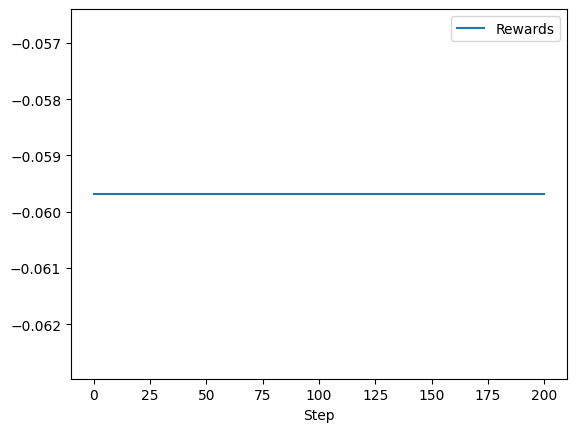

In [16]:
plt.plot(rewards, label="Rewards")
plt.xlabel('Step')
plt.legend()
plt.show()

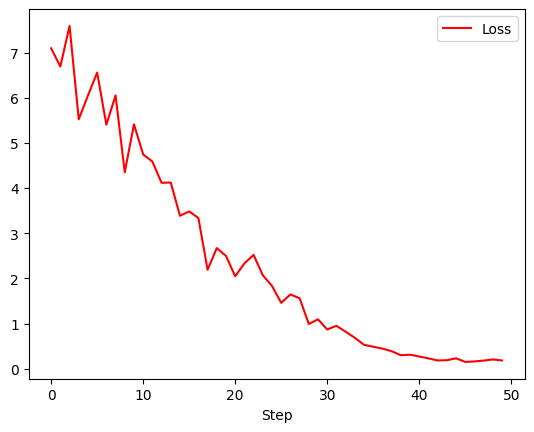

In [12]:
plt.plot(loss, label="Loss", c='r')
# plt.plot(rewards, label="Rewards")
plt.xlabel('Step')
plt.legend()
plt.show()

Save to checkpoint.

In [ ]:
# train_checkpointer.save(global_step)

# WandB

In [8]:
! export WANDB_NOTEBOOK_NAME="main.ipynb"
import wandb

PROJECT_NAME = "Reinforcement Learning (DQN) - JVM-GC"
WANDB_KEY = "4b077df3688052b0f43705d6b4d712c05fb979b7"
config = dict(
    competition = PROJECT_NAME,
    _wandb_kernel = 'lemon',
    seed = 42,
)

In [9]:
# Set this to True when you want to run hyperparameter tuning
hyperparameter_tuning = True

def main():
    run = wandb.init(config = config)
    
    _learning_rate = run.config.learning_rate
    _epsilon_greedy = run.config.epsilon_greedy
    _target_update_period = run.config.target_update_period
    _gamma = run.config.gamma
    
    optimizer = tf.compat.v1.train.AdamOptimizer(
        learning_rate=_learning_rate)

    _agent = dqn_agent.DqnAgent(
        time_step_spec,
        action_spec,
        q_network = q_net,
        optimizer = optimizer,
        n_step_update = n_step_update,
        td_errors_loss_fn = tf.keras.losses.MeanSquaredError(),
        epsilon_greedy = _epsilon_greedy,
        target_update_period = _target_update_period,
        gamma = _gamma,
        gradient_clipping = gradient_clipping, # [-1, 1]
    )

    loss, _, rewards = train(_agent, train_env, eval_env, steps = 5000, use_wandb = True)
    
    wandb.log({'avg_loss': np.mean(loss), 'avg_reward': np.mean(rewards)})

    del _agent
    return

# Define sweep config
sweep_configuration = {
    'method': 'random',
    'name': 'rl_greed',
    "metric": {
        "name" : "avg_reward",
        "goal": "maximize"
    },
    "parameters" : {
        "learning_rate": {
            "min": 0.0001,
            "max": 0.01
        },
        "epsilon_greedy": {'values': [0.1, 0.3, 0.5, 0.7, 0.9]},
        "target_update_period": {'values': [1, 10, 100, 1000, 10000]},
        "gamma": {'values': [0.1, 0.3, 0.5, 0.7, 0.9]},
    },
    'run_cap' : 32
}

if hyperparameter_tuning:
    ! export WANDB_NOTEBOOK_NAME="main.ipynb"
    # Initialize sweep by passing in config. (Optional) Provide a name of the project.
    sweep_id = wandb.sweep(sweep=sweep_configuration, project=PROJECT_NAME,)

    # Start sweep job.
    wandb.agent(sweep_id, function=main)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: srh8mikx
Sweep URL: https://wandb.ai/cold-machines/Reinforcement%20Learning%20%28DQN%29%20-%20JVM-GC/sweeps/srh8mikx


wandb: Agent Starting Run: 86wuplng with config:
wandb: 	epsilon_greedy: 0.7
wandb: 	gamma: 0.1
wandb: 	learning_rate: 0.009081865474555018
wandb: 	target_update_period: 100
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: valeriia-sakovskaia (cold-machines). Use `wandb login --relogin` to force relogin


  0%|          | 0/5000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
  2%|▏         | 101/5000 [00:16<18:44,  4.36it/s]

step = 100: loss = 0.051988594233989716, reward = -0.05968308076262474


  4%|▍         | 201/5000 [00:32<17:56,  4.46it/s]

step = 200: loss = 0.04959993064403534, reward = -0.05968308076262474


  6%|▌         | 301/5000 [00:48<17:17,  4.53it/s]

step = 300: loss = 0.05310416966676712, reward = -0.05968308076262474


  8%|▊         | 401/5000 [01:04<21:05,  3.64it/s]

step = 400: loss = 0.07190939784049988, reward = -0.05968308076262474


 10%|█         | 501/5000 [01:20<16:40,  4.50it/s]

step = 500: loss = 0.06140190362930298, reward = -0.05968308076262474


 12%|█▏        | 601/5000 [01:36<16:26,  4.46it/s]

step = 600: loss = 0.07814410328865051, reward = -0.05968308076262474


 14%|█▍        | 701/5000 [01:53<16:30,  4.34it/s]

step = 700: loss = 0.05395403504371643, reward = -0.05968308076262474


 16%|█▌        | 801/5000 [02:08<15:39,  4.47it/s]

step = 800: loss = 0.05778862535953522, reward = -0.05968308076262474


 18%|█▊        | 901/5000 [02:25<14:59,  4.56it/s]

step = 900: loss = 0.05692460760474205, reward = -0.05968308076262474


 20%|██        | 1001/5000 [02:41<15:17,  4.36it/s]

step = 1000: loss = 0.059485163539648056, reward = -0.05968308076262474


 22%|██▏       | 1101/5000 [02:57<14:36,  4.45it/s]

step = 1100: loss = 0.07164233177900314, reward = -0.05968308076262474


 24%|██▍       | 1201/5000 [03:14<14:20,  4.41it/s]

step = 1200: loss = 0.04963871091604233, reward = -0.05968308076262474


 26%|██▌       | 1301/5000 [03:30<14:23,  4.28it/s]

step = 1300: loss = 0.05595877766609192, reward = -0.05968308076262474


 28%|██▊       | 1401/5000 [03:46<13:25,  4.47it/s]

step = 1400: loss = 0.05879542976617813, reward = -0.05968308076262474


 30%|███       | 1501/5000 [04:02<12:52,  4.53it/s]

step = 1500: loss = 0.06716286391019821, reward = -0.05968308076262474


 32%|███▏      | 1601/5000 [04:18<13:14,  4.28it/s]

step = 1600: loss = 0.05800986662507057, reward = -0.05968308076262474


 34%|███▍      | 1701/5000 [04:35<12:29,  4.40it/s]

step = 1700: loss = 0.06368903815746307, reward = -0.05968308076262474


 36%|███▌      | 1801/5000 [04:51<12:38,  4.22it/s]

step = 1800: loss = 0.05840213596820831, reward = -0.05968308076262474


 38%|███▊      | 1901/5000 [05:07<11:47,  4.38it/s]

step = 1900: loss = 0.06790091097354889, reward = -0.05968308076262474


 40%|████      | 2001/5000 [05:24<11:03,  4.52it/s]

step = 2000: loss = 0.05456307530403137, reward = -0.05968308076262474


 42%|████▏     | 2101/5000 [05:39<10:43,  4.51it/s]

step = 2100: loss = 0.05199477821588516, reward = -0.05968308076262474


 44%|████▍     | 2201/5000 [05:56<10:51,  4.30it/s]

step = 2200: loss = 0.046316057443618774, reward = -0.05968308076262474


 46%|████▌     | 2301/5000 [06:12<09:51,  4.56it/s]

step = 2300: loss = 0.0451720654964447, reward = -0.05968308076262474


 48%|████▊     | 2401/5000 [06:28<09:59,  4.34it/s]

step = 2400: loss = 0.05063679814338684, reward = -0.05968308076262474


 50%|█████     | 2501/5000 [06:44<09:13,  4.51it/s]

step = 2500: loss = 0.05682305246591568, reward = -0.05968308076262474


 52%|█████▏    | 2601/5000 [07:01<08:57,  4.46it/s]

step = 2600: loss = 0.057316817343235016, reward = -0.05968308076262474


 54%|█████▍    | 2701/5000 [07:17<08:40,  4.42it/s]

step = 2700: loss = 0.06233186647295952, reward = -0.05968308076262474


 56%|█████▌    | 2801/5000 [07:34<08:08,  4.50it/s]

step = 2800: loss = 0.030263567343354225, reward = -0.05968308076262474


 58%|█████▊    | 2901/5000 [07:49<07:45,  4.51it/s]

step = 2900: loss = 0.12275780737400055, reward = -0.05968308076262474


 60%|██████    | 3001/5000 [08:06<07:35,  4.39it/s]

step = 3000: loss = 0.0640171468257904, reward = -0.05968308076262474


 62%|██████▏   | 3101/5000 [08:22<07:06,  4.45it/s]

step = 3100: loss = 0.06743437051773071, reward = -0.05968308076262474


 64%|██████▍   | 3201/5000 [08:39<07:00,  4.27it/s]

step = 3200: loss = 0.07279805094003677, reward = -0.05968308076262474


 66%|██████▌   | 3301/5000 [08:55<06:22,  4.45it/s]

step = 3300: loss = 0.03942070156335831, reward = -0.05968308076262474


 68%|██████▊   | 3401/5000 [09:12<06:25,  4.14it/s]

step = 3400: loss = 0.06413926929235458, reward = -0.05968308076262474


 70%|███████   | 3501/5000 [09:27<05:42,  4.38it/s]

step = 3500: loss = 0.04303019493818283, reward = -0.05968308076262474


 72%|███████▏  | 3601/5000 [09:43<05:13,  4.46it/s]

step = 3600: loss = 0.0326034352183342, reward = -0.05968308076262474


 74%|███████▍  | 3701/5000 [10:00<04:56,  4.38it/s]

step = 3700: loss = 0.06070145219564438, reward = -0.05968308076262474


 76%|███████▌  | 3801/5000 [10:16<04:34,  4.37it/s]

step = 3800: loss = 0.05568353831768036, reward = -0.05968308076262474


 78%|███████▊  | 3901/5000 [10:33<04:09,  4.40it/s]

step = 3900: loss = 0.0671439915895462, reward = -0.05968308076262474


 80%|████████  | 4001/5000 [10:49<03:42,  4.49it/s]

step = 4000: loss = 0.07973361760377884, reward = -0.05968308076262474


 82%|████████▏ | 4101/5000 [11:06<03:38,  4.11it/s]

step = 4100: loss = 0.05744113028049469, reward = -0.05968308076262474


 84%|████████▍ | 4201/5000 [11:22<03:00,  4.44it/s]

step = 4200: loss = 0.04437218979001045, reward = -0.05968308076262474


 86%|████████▌ | 4301/5000 [11:37<02:34,  4.51it/s]

step = 4300: loss = 0.06655722111463547, reward = -0.05968308076262474


 88%|████████▊ | 4401/5000 [11:55<02:13,  4.49it/s]

step = 4400: loss = 0.054657574743032455, reward = -0.05968308076262474


 90%|█████████ | 4501/5000 [12:10<01:51,  4.49it/s]

step = 4500: loss = 0.05559392273426056, reward = -0.05968308076262474


 92%|█████████▏| 4601/5000 [12:27<01:32,  4.31it/s]

step = 4600: loss = 0.062225304543972015, reward = -0.05968308076262474


 94%|█████████▎| 4678/5000 [12:39<00:49,  6.51it/s]

### Restore checkpoint

In [ ]:
def test(policy, test_env, num_episodes: int=10000):
    rewards = []
    log_interval = 100
    time_step = test_env.reset()
    total_return = 0.0
    for i in tqdm(range(10000)):
        policy_state = policy.action(time_step)
        time_step = test_env.step(policy_state.action)
        reward = time_step.reward.numpy()[0]
        total_return += reward # Calculate a sum of rewards

        if i % log_interval == 0:
            # avg_return = compute_avg_return(eval_env, agent.policy, 10)
            avg_return = total_return / eval_interval
            print('step = {0}: Average reward = {1:.5f}'.format(step, avg_return))
            rewards.append(avg_return)
            total_return = 0.0 # reset
    return rewards

# test(agent.policy, test_env)